**WARNING: this file is no longer maintained.**
A neat version of the functions designed here
can be found in `rolim/encoder/pairwise_sampler.py`.

# Loading the CIFAR10 dataset
This notebook is a sandbox, used to explore the
loading of a dataset and iterating over it.
In particular, the CIFAR10 dataset.

## Goal
To find a way to sample batches
of random pairs of images, such that
both images in each pair have the same class.
Classes between pairs may (*should* randomly) differ.

In [1]:
import math
import numpy as np
from typing import Iterator
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torchvision as vision
from torchvision.utils import make_grid


from rolim.settings import CIFAR10_DIR

trainset = vision.datasets.CIFAR10(root=CIFAR10_DIR, train=True, download=True)
testset = vision.datasets.CIFAR10(root=CIFAR10_DIR, train=False, download=False)
RNG = np.random.default_rng()

/home/nifrec/.pyenv/versions/3.10_default/envs/rolim/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


## What I discovered along the way:
* A PyTorch dataset (`torch.utils.Dataset`) from `torchvision` is quite straightforward:
    * `dataset.classes` provides a list of the distinct class names.
    * `dataset.data` stores all images in a list-like structure.
    * `dataset.targets` is of the same length as `dataset.data`,
        and contains the index of the class label for each image in the data.
        This stored index is the index of the class label in `dataset.classes`.
    * A `Sampler` is a class that simply returns indices of images
        in a dataset (corresponding to indices in `dataset.data`).
        You can create your own implementation to sample data the way you like to.
    * `BatchSampler` is a wrapper around other `Sampler` instances
        that samples *lists of* indices. Of course, you can also
        implement a different class that samples multiple
        indices in the way you like to, and pass it to `DataLoader`.
    * The `DataLoader` is used during training to directly query for images.
* CIFAR10 images are of chape `(32, 32, 3)`. So H×W×C with RGB colours.
    This is the format used by Numpy.
    PyTorch uses the B×C×H×W convention, but one convert from the numpy
    to the PyTorch convention using `torchvision.transforms.ToTensor`.
    (`torchvision.transforms.ToPILImage` does the inverse transformation).

In [2]:
print(trainset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
import numpy as np
# Inspired from:
# https://discuss.pytorch.org/t/how-to-sample-images-belonging-to-particular-classes/43776/6
def get_indices_per_class(dataset: torch.utils.data.Dataset):
    output = []
    targets = np.array(dataset.targets) # List giving the class idx for each image
    for class_idx in range(len(trainset.classes)):
        class_name = trainset.classes
        output.append(np.where(targets == class_idx)[0])
    return output

indices_per_class = get_indices_per_class(testset)

In [4]:
class PairSampler(torch.utils.data.Sampler):

    def __init__(self, 
                dataset: torch.utils.data.Dataset, 
                rng: np.random.Generator, 
                epoch_size:int):
        super().__init__(dataset)
        self.__dataset = dataset
        # List that maps the index of a class to a list of
        # image indices of that class.
        self.__indices_per_class: list[list[int]] = get_indices_per_class(dataset)
        self.__num_classes: int = len(dataset.classes)
        self.__rng = rng

        if epoch_size % 2 != 0:
            raise ValueError(f"Epoch size must be even, got: {epoch_size}")
        self.__epoch_size = epoch_size
        
        assert self.__num_classes == len(self.__indices_per_class)

    @property
    def num_classes(self) -> int:
        return self.__num_classes

    @property
    def epoch_size(self) -> int:
        """
        Number of images returned before iteration halts.
        """
        return self.__epoch_size

    def sample_from_class_idx(self, class_idx: int) -> Tensor:
        """
        Randomly sample an image whose class has the given
        index in the dataset's list of class labels.
        """
        all_indices = self.__indices_per_class[class_idx]
        idx = self.__rng.choice(all_indices)
        image = self.__dataset.data[idx]
        return torch.from_numpy(image)

    def sample_from_class_label(self, label:str) -> Tensor:
        """
        Randomly sample an image whose class label is `label`.
        """
        class_idx = self.__dataset.classes.index(label)
        return self.sample_from_class_idx(class_idx)

    def sample_random_class_idx(self) -> int:
        """
        Sample a random class-label-index
        in the range `0, self.num_classes-1`.
        """
        return int(self.__rng.integers(self.num_classes))

    def __iter__(self) -> Iterator[int]:
        """
        Randomly sample indices from the dataset.
        The indices come in pairs, such that each
        index in the pair refers to an element of the same class.
        After two yielded indices, a new class is sampled uniformly.
        Within a class, the elements of the pairs are sampled
        uniformly. All sampling is performed with replacement;
        it is possible a pair consist of the same index twice.
        """
        current_class = self.sample_random_class_idx()
        for _ in range(self.epoch_size//2):
            yield self.sample_from_class_idx(current_class)
            yield self.sample_from_class_idx(current_class)
            current_class = self.sample_random_class_idx()




    def __len__(self) -> int:
        return self.epoch_size

## Try out visually if `PairSampler` returns the right classes
Seems correct, all horses indeex, and not the same every time.
Rerunning the code below results in different picures,
indicating it is indeed randomized.

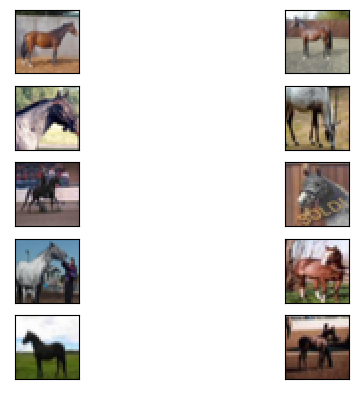

In [5]:
pair_sampler = PairSampler(trainset, RNG, 10)
num_images = 10
images = [pair_sampler.sample_from_class_label("horse")
            for _ in range(num_images)]


def plot_paired_images(images: list[Tensor]):
    num_rows = math.ceil(len(images)/2)
    num_cols = 2 # Since pairs of images    
    make_grid(images, nrow=num_rows, ncol=num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)
    for idx, image in enumerate(images):    
        row = idx // num_cols 
        col = idx % num_cols
        axes[row, col].imshow(np.asarray(image))
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plot_paired_images(images)

## Making it compatible with the DataLoader
From the `torchvision` source code, `BatchSampler`
is indeed a simple wrapper that samples indices from another sampler,
accumulates them in a list, and return this list when the batch size has been met.
Then it empties the list and repeats.

We can do something similar, but then a little bit more complicated:
1. For each pair of indices, first sample a class (uniformly,
    so just a random index in range(10)).
2. Then use PairSampler to sample 2 images of that class.
3. Add the pair to the batch, and repeat from 1. if needed.
Obviously, batch sizes must be even.

In [6]:
class PairWiseBatchSampler(PairSampler):
    """
    Sampler that returns a batch of indices [x_0, x_1, x_2, ..., x_{N}, x_{N+1}] 
    from a dataset such that every two consecutive indices
    belong to dataset-elements of the same class
    (i.e., (x_0, x_1) have the same class, (x_2, x_3) have the same class, etc.).
    The classes for each pair are randomly uniformly sampled,
    and given a class, the pair elements are also uniformly sampled
    from all elements of the given class.
    """

    def __init__(self, dataset: torch.utils.data.Dataset, 
                 rng: np.random.Generator,
                 batch_size:int,
                 epoch_size: int):
        """
        Arguments:
        * dataset: a map-style PyTorch dataset, e.g. CIFAR10.
        * rng: number generator used for the randomness in the sampling.
        * batch_size: number *pairs* per batch.
            Each batch thus contains `2*batch_size` images.
        * epoch_size: even integer, number of images returned
            before iteration halts. Images are sampled
            with replacement from the dataset, so this
            number may exceed the dataset size.
        """
        super().__init__(dataset, rng, epoch_size)
        self.__batch_size = batch_size
        if epoch_size % 2 != 0:
            raise ValueError(f"Epoch size must be even, got: {epoch_size}")


    @property
    def batch_size(self) -> int:
        """
        Return the number of pairs of indices in each batch.
        """
        return self.__batch_size



    def __iter__(self) -> Iterator[list[int]]:
        super_iterator = super().__iter__()
        budget = self.epoch_size
        while budget >= self.batch_size:
            batch = [next(super_iterator) for _ in range(self.batch_size)]
            budget -= self.batch_size
            yield batch

## Visual test of `PairWiseBatchSampler`
Sample one batch of 10 pairs.
Are different classes present,
and does each pair have the same class?

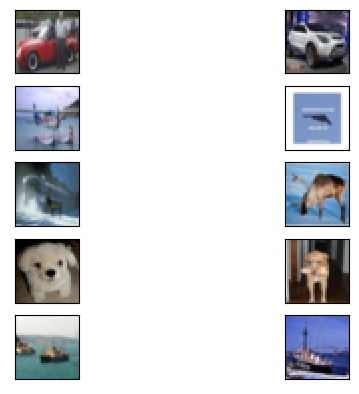

In [7]:
sampler = PairWiseBatchSampler(trainset, RNG, 10, 20)
sample = next(iter(sampler))
plot_paired_images(sample)
